In [5]:
import os
import cv2
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

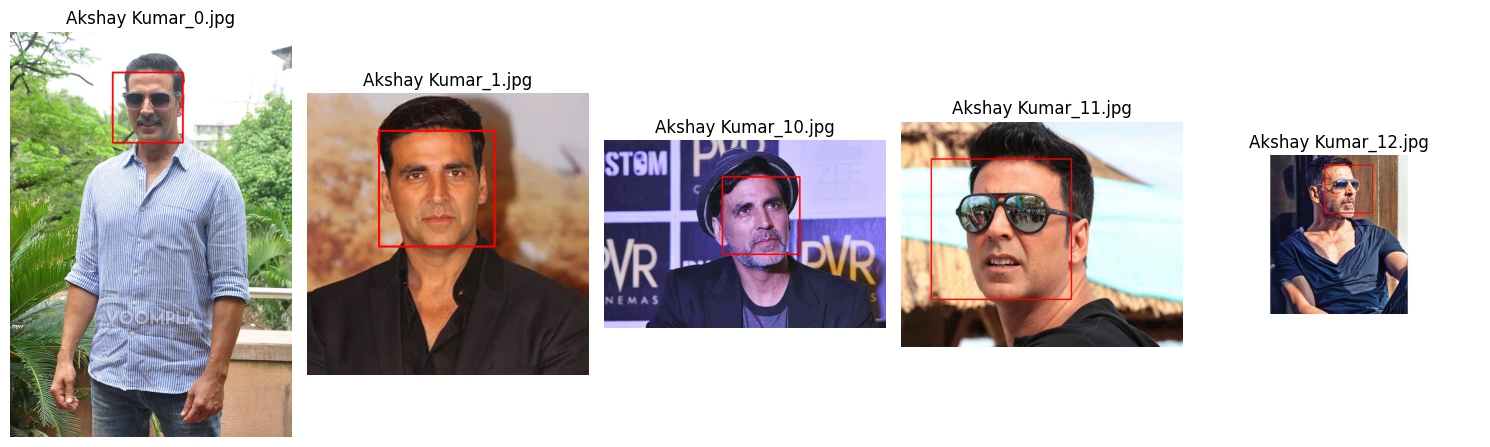

In [14]:
# загружаем метки в формате json
with open('faces.json', 'r') as f:
    labels_dict = json.load(f)

# кол-во примеров для втзуализации
samples_num = 5
sample_images = list(labels_dict.keys())[:samples_num]

fig, axes = plt.subplots(1, samples_num, figsize=(15, 5))

for i, img_path in enumerate(sample_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x, y, w, h = labels_dict[img_path]

    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 4)

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(os.path.basename(img_path))  # Название файла

plt.tight_layout()
plt.show()



In [26]:
# Загружаем JSON с метками
with open("faces.json", "r") as f:
    faces_dict = json.load(f)

X_train = []
Y_train = []

for img_path, bbox in faces_dict.items():
    img = cv2.imread(img_path)

    if img is not None:
        h, w, _ = img.shape  # Размер изображения
        
        # Нормализуем bbox
        x, y, bw, bh = bbox
        x_norm = x / w
        y_norm = y / h
        bw_norm = bw / w
        bh_norm = bh / h

        # Подготовка изображения
        img = cv2.resize(img, (192, 192))
        img = img / 255.0  # Нормализация

        # Добавляем в dataset
        X_train.append(img)
        Y_train.append([x_norm, y_norm, bw_norm, bh_norm])

# Преобразуем в numpy
X_train = np.array(X_train)
Y_train = np.array(Y_train)

print("Готово! Размер X_train:", X_train.shape)
print("Размер Y_train (bbox):", Y_train.shape)

Готово! Размер X_train: (2476, 192, 192, 3)
Размер Y_train (bbox): (2476, 4)


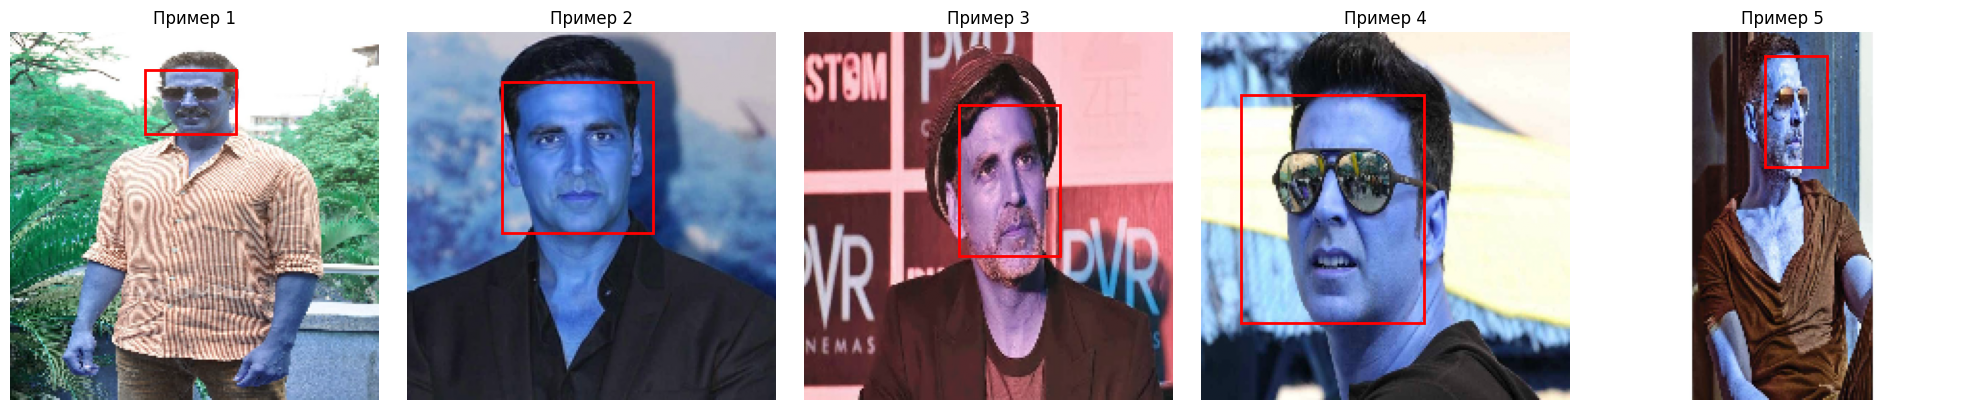

In [27]:
import matplotlib.patches as patches
img_width, img_height = 192, 192
num_examples = 5
fig, axes = plt.subplots(1, num_examples, figsize=(num_examples * 4, 4))

for i in range(num_examples):
    img = X_train[i]
    bbox = Y_train[i]  # [x_norm, y_norm, bw_norm, bh_norm]

        # Пересчитываем координаты
    x = bbox[0] * img_width
    y = bbox[1] * img_height
    bw = bbox[2] * img_width
    bh = bbox[3] * img_height
    
    ax = axes[i]
    ax.imshow(img)
    # Создаем прямоугольник, используя matplotlib.patches.Rectangle:
    rect = patches.Rectangle((x, y), bw, bh, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.set_title(f"Пример {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(4, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()
    

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 190, 190, 32)      896       
                                                                 
 batch_normalization_9 (Batc  (None, 190, 190, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 95, 95, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 93, 93, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 93, 93, 64)       256       
 chNormalization)                                                
                                                      

In [29]:
history = model.fit(
    X_train, Y_train,
    epochs=20, batch_size=32,
    validation_split=0.2,
    verbose=1
)

model.save('detecto.keras')

Epoch 1/20
62/62 [==============================] - 4s 51ms/step - loss: 0.0965 - mae: 0.2426 - val_loss: 0.3765 - val_mae: 0.5791
Epoch 2/20
62/62 [==============================] - 2s 36ms/step - loss: 0.0461 - mae: 0.1659 - val_loss: 0.1403 - val_mae: 0.2867
Epoch 3/20
62/62 [==============================] - 2s 36ms/step - loss: 0.0332 - mae: 0.1422 - val_loss: 0.0850 - val_mae: 0.2422
Epoch 4/20
62/62 [==============================] - 2s 36ms/step - loss: 0.0258 - mae: 0.1246 - val_loss: 0.0342 - val_mae: 0.1547
Epoch 5/20
62/62 [==============================] - 2s 35ms/step - loss: 0.0211 - mae: 0.1130 - val_loss: 0.0251 - val_mae: 0.1279
Epoch 6/20
62/62 [==============================] - 2s 36ms/step - loss: 0.0169 - mae: 0.0997 - val_loss: 0.0267 - val_mae: 0.1289
Epoch 7/20
62/62 [==============================] - 2s 36ms/step - loss: 0.0144 - mae: 0.0912 - val_loss: 0.0186 - val_mae: 0.1010
Epoch 8/20
62/62 [==============================] - 2s 35ms/step - loss: 0.0118 - m

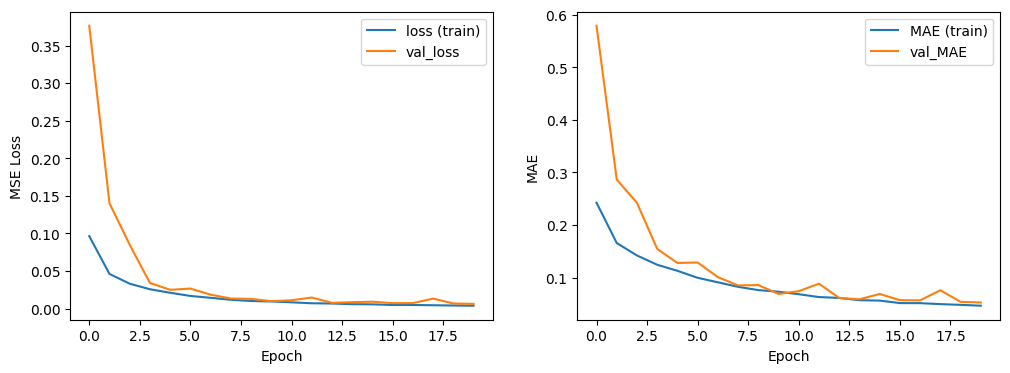

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss (train)')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE (train)')
plt.plot(history.history['val_mae'], label='val_MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

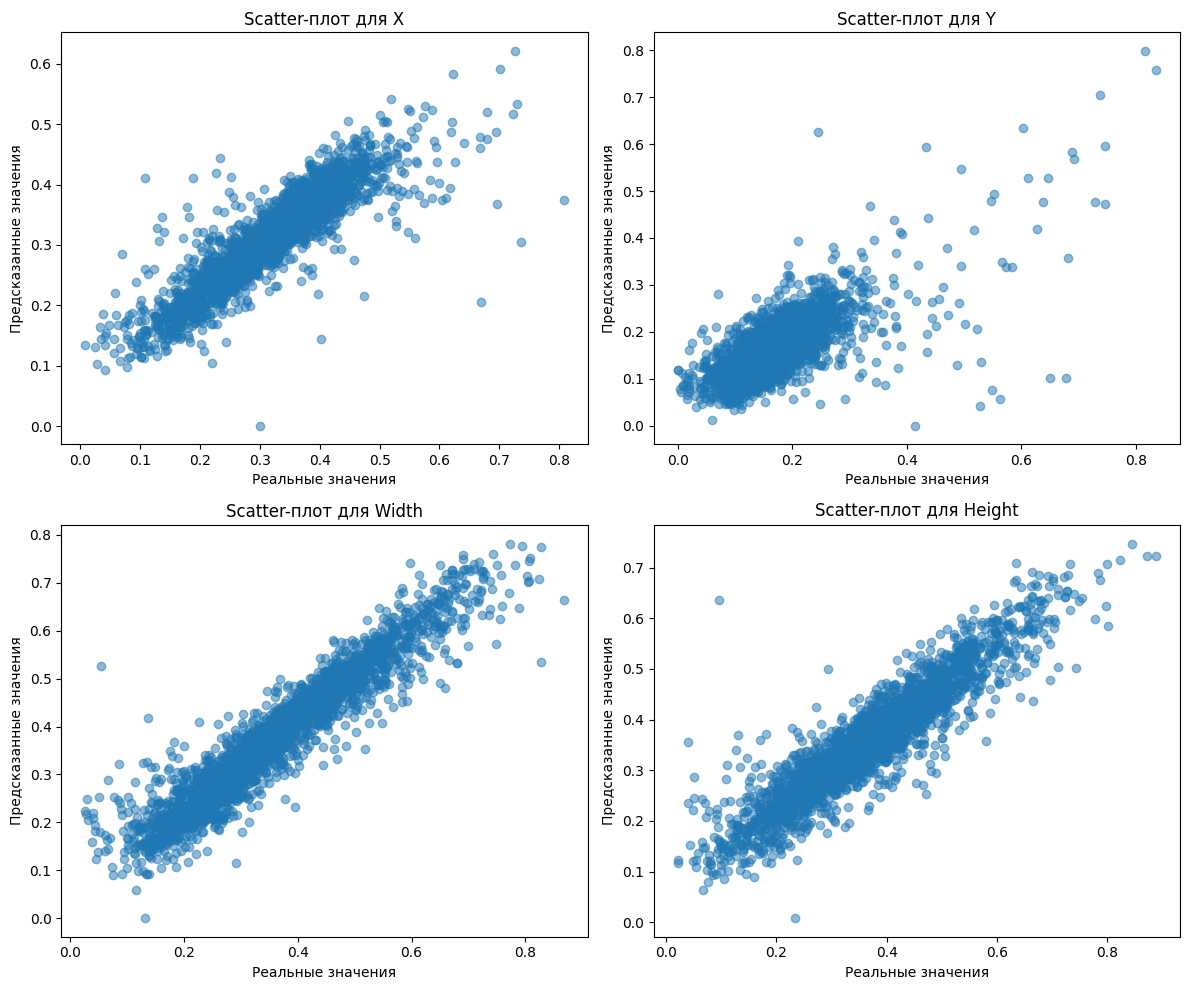

In [31]:
# Предсказываем координаты на тестовых данных
Y_pred = model.predict(X_train)

# Визуализируем предсказания vs реальные значения
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
labels = ['X', 'Y', 'Width', 'Height']

for i, ax in enumerate(axes.flat):
    ax.scatter(Y_train[:, i], Y_pred[:, i], alpha=0.5)
    ax.set_xlabel("Реальные значения")
    ax.set_ylabel("Предсказанные значения")
    ax.set_title(f"Scatter-плот для {labels[i]}")

plt.tight_layout()
plt.show()

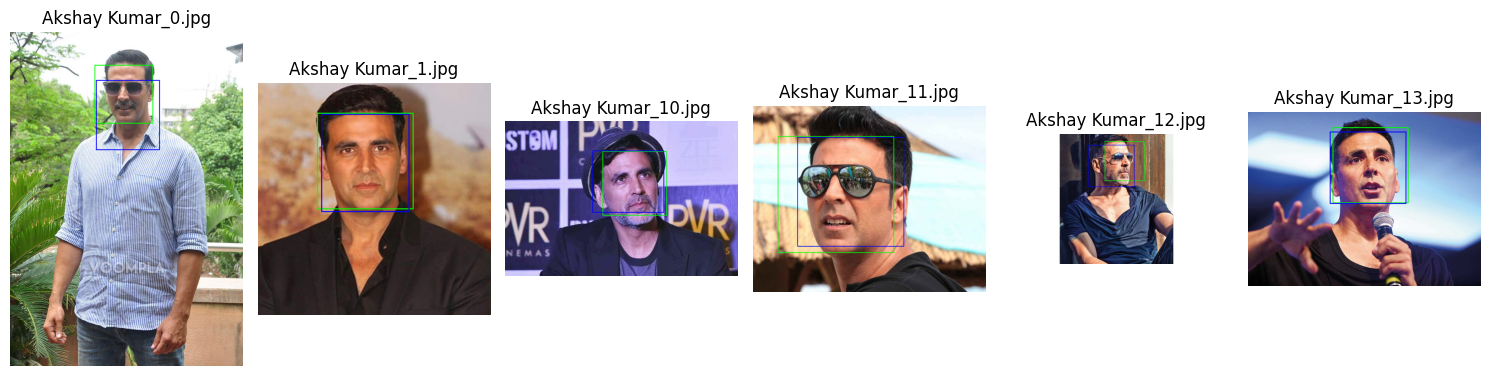

In [33]:
# Количество изображений для отображения
N = 6
sample_images = list(faces_dict.keys())[:N]

fig, axes = plt.subplots(1, N, figsize=(15, 5))

for i, img_path in enumerate(sample_images):
    img = cv2.imread(img_path)
    h, w, _ = img.shape  # Размер оригинального изображения

    # Загружаем нормализованный bbox из разметки
    x_gt, y_gt, bw_gt, bh_gt = faces_dict[img_path]

    # Нормализация для подачи в модель
    img_resized = cv2.resize(img, (192, 192))
    img_resized = img_resized / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)

    # Предсказание bbox
    bbox_pred = model.predict(img_resized)[0]

    # Де-нормализация предсказанного bbox
    x_pred = int(bbox_pred[0] * w)
    y_pred = int(bbox_pred[1] * h)
    bw_pred = int(bbox_pred[2] * w)
    bh_pred = int(bbox_pred[3] * h)

    # Рисуем реальный bbox (зелёный)
    cv2.rectangle(img, (x_gt, y_gt), (x_gt + bw_gt, y_gt + bh_gt), (0, 255, 0), 2)

    # Рисуем предсказанный bbox (красный)
    cv2.rectangle(img, (x_pred, y_pred), (x_pred + bw_pred, y_pred + bh_pred), (255, 0, 0), 2)

    # Переводим в RGB для matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Отображаем
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(os.path.basename(img_path))

plt.tight_layout()
plt.show()